In [ ]:
#逻辑回归步骤
#①运用随机森林进行变量的重要性选择
#②数据清洗：离群值、空缺值、极端值、数据离散化
#③数据细选：IV值，p值、向前法向后法、离散化进行woe打分或哑变量变换
#④根据回归效果进行调参：正则化交叉验证，根据业务生成scoring（recall,accruacy,f1_score）、过拟合判断PSI
#⑤回到第二步进一步优化：标准化、生成新变量，再进行效果评估
#⑥预测：阈值选择

In [2]:
#逻辑回归
#数据说明:本数据是一份汽车贷款违约数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
pd.set_option('display.max_columns',None)

In [4]:
#导入数据
accepts = pd.read_csv('C:\\Users\\acerpc\\Desktop\\code&data\\accepts.csv',skipinitialspace=True)
accepts = accepts.dropna(axis=0,how='any')
accepts.head()

,application_id,account_number,bad_ind,vehicle_year,vehicle_make,bankruptcy_ind,tot_derog,tot_tr,age_oldest_tr,tot_open_tr,tot_rev_tr,tot_rev_debt,tot_rev_line,rev_util,fico_score,purch_price,msrp,down_pyt,loan_term,loan_amt,ltv,tot_income,veh_mileage,used_ind,weight
0,2314049,11613,1,1998.0,FORD,N,7.0,9.0,64.0,2.0,1.0,506.0,500.0,101,650.0,17200.00,17350.0,0.00,36,17200.00,99.0,6550.00,24000.0,1,1.00
1,63539,13449,0,2000.0,DAEWOO,N,0.0,21.0,240.0,11.0,7.0,34605.0,57241.0,60,649.0,19588.54,19788.0,683.54,60,19588.54,99.0,4666.67,22.0,0,4.75
3,8725187,15359,1,1997.0,FORD,N,3.0,10.0,35.0,5.0,4.0,4019.0,5946.0,68,603.0,12999.00,12100.0,3099.00,60,10800.00,118.0,1500.00,10000.0,1,1.00
4,4275127,15812,0,2000.0,TOYOTA,N,0.0,10.0,104.0,2.0,0.0,0.0,1800.0,0,764.0,26328.04,22024.0,0.00,60,26328.04,122.0,4144.00,14.0,0,4.75
5,8712513,16979,0,2000.0,DODGE,Y,2.0,15.0,136.0,4.0,3.0,3651.0,5747.0,64,680.0,26272.72,26375.0,0.00,36,26272.72,100.0,5400.00,1.0,0,4.75


In [6]:
#分类变量的相关关系
#曾经破产标识与是否违约是否有关系?
#交叉表
crosstab = pd.crosstab(accepts.bankruptcy_ind,accepts.bad_ind,margins=True)
crosstab

bad_ind,0,1,All
bankruptcy_ind,,,
N,3076,719,3795
Y,243,67,310
All,3319,786,4105


In [8]:
#列联表
def perconvert(ser):
    return ser/ser[-1]
crosstab.apply(perconvert,axis=1)

bad_ind,0,1,All
bankruptcy_ind,,,
N,0.810540,0.189460,1.0
Y,0.783871,0.216129,1.0
All,0.808526,0.191474,1.0


In [12]:
#卡方检验
print('chiq=%f,p_value=%f,dof=%i,\nexpexcted=%s'%stats.chi2_contingency(crosstab.iloc[:2,:2]))

chiq=1.150037,p_value=0.283541,dof=1,
expexcted=[[3068.35688185  726.64311815]
 [ 250.64311815   59.35688185]]


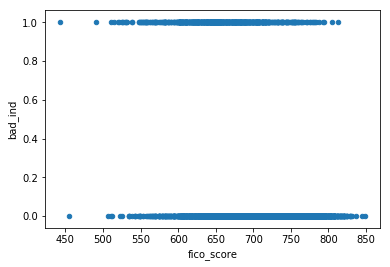

In [14]:
#逻辑回归
accepts.plot('fico_score','bad_ind',kind='scatter')

In [16]:
#随机抽样，建立训练集与测试集
train = accepts.sample(frac=0.7,random_state=2).copy()
test = accepts[~accepts.index.isin(train.index)].copy()
print('训练集样本量%i,测试集样本量%i'%(len(train),len(test)))

训练集样本量2874,测试集样本量1231


In [18]:
lr = smf.glm('bad_ind~fico_score',data=train,family=sm.families.Binomial(sm.families.links.logit)).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                bad_ind   No. Observations:                 2874
Model:                            GLM   Df Residuals:                     2872
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1225.8
Date:                Sun, 02 Dec 2018   Deviance:                       2451.6
Time:                        10:21:28   Pearson chi2:                 2.78e+03
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7250      0.653     13.363      0.000       7.445      10.005
fico_score    -0.0150      0.001    -15.426      0.000      -0.017      -0.013
==============================================================================
"""

In [19]:
#Duoyuan
formula = 'bad_ind~fico_score + bankruptcy_ind+ tot_derog + age_oldest_tr + rev_util + ltv + veh_mileage'
lr_m = smf.glm(formula,data=train,family=sm.families.Binomial(sm.families.links.logit)).fit()
lr_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                bad_ind   No. Observations:                 2874
Model:                            GLM   Df Residuals:                     2866
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1160.6
Date:                Sun, 02 Dec 2018   Deviance:                       2321.3
Time:                        10:26:00   Pearson chi2:                 2.70e+03
No. Iterations:                     6   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.1395      0.838      6.132      0.000       3.497       6.782
bankruptcy_ind[T.Y]    -0.5247      0.201     -2.613      0.009      -0.918      -0.131
fico_score             -0.0138      0.001    -11.485      0.000      -0.016      -0.011
tot_derog               0.0434      0.018      2.439      0.015       0.009       0.078
age_oldest_tr          -0.0034      0.001     -5.381      0.000      -0.005      -0.002
rev_util                0.0013      0.001      2.002      0.045    2.68e-05       0.003
ltv                     0.0299      0.004      8.403      0.000       0.023       0.037
veh_mileage          1.546e-06    1.4e-06      1.107      0.268   -1.19e-06    4.28e-06
=======================================================================================
"""

In [21]:
# 向前法选择变量
def forward_select(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        aic_with_candidates=[]
        for candidate in remaining:
            formula = "{} ~ {}".format(
                response,' + '.join(selected + [candidate]))
            aic = smf.glm(
                formula=formula, data=data, 
                family=sm.families.Binomial(sm.families.links.logit)
            ).fit().aic
            aic_with_candidates.append((aic, candidate))
        aic_with_candidates.sort(reverse=True)
        best_new_score, best_candidate=aic_with_candidates.pop()
        if current_score > best_new_score: 
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print ('aic is {},continuing!'.format(current_score))
        else:        
            print ('forward selection over!')
            break
            
    formula = "{} ~ {} ".format(response,' + '.join(selected))
    print('final formula is {}'.format(formula))
    model = smf.glm(
        formula=formula, data=data, 
        family=sm.families.Binomial(sm.families.links.logit)
    ).fit()
    return(model)

In [22]:
#建模
candidates = ['bad_ind', 'fico_score', 'bankruptcy_ind', 'tot_derog',
              'age_oldest_tr', 'rev_util', 'ltv', 'veh_mileage']
data_to_select = train[candidates]
model = forward_select(data_to_select,'bad_ind')
model.summary()

aic is 2455.6394030256392,continuing!
aic is 2371.431399785047,continuing!
aic is 2344.216794399271,continuing!
aic is 2342.3191913194396,continuing!
aic is 2340.429125120842,continuing!
aic is 2336.449044971725,continuing!
forward selection over!
final formula is bad_ind ~ fico_score + ltv + age_oldest_tr + rev_util + bankruptcy_ind + tot_derog 


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                bad_ind   No. Observations:                 2874
Model:                            GLM   Df Residuals:                     2867
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1161.2
Date:                Sun, 02 Dec 2018   Deviance:                       2322.4
Time:                        10:34:20   Pearson chi2:                 2.70e+03
No. Iterations:                     6   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.1914      0.837      6.204      0.000       3.551       6.832
bankruptcy_ind[T.Y]    -0.5269      0.201     -2.625      0.009      -0.920      -0.134
fico_score             -0.0138      0.001    -11.552      0.000      -0.016      -0.011
ltv                     0.0302      0.004      8.474      0.000       0.023       0.037
age_oldest_tr          -0.0034      0.001     -5.408      0.000      -0.005      -0.002
rev_util                0.0013      0.001      1.982      0.047     1.4e-05       0.002
tot_derog               0.0439      0.018      2.472      0.013       0.009       0.079
=======================================================================================
"""

In [52]:
#膨胀因子检验
from statsmodels.formula.api import ols
def vif_(data):
    vif = []
    for col in data.columns:
        cols = list(data.columns)
        cols.remove(col)
        formula = col + '~' + '+'.join(cols)
        rsquared = ols(formula=formula,data=data).fit().rsquared
        vif.append(1/(1-rsquared))
    return pd.DataFrame({'col':data.columns,'vif':vif})

In [59]:
vif = vif_(train[candidates].drop(['bad_ind', 'bankruptcy_ind'],axis=1))
vif

,col,vif
0,fico_score,1.567113
1,tot_derog,1.367728
2,age_oldest_tr,1.119734
3,rev_util,1.107306
4,ltv,1.024622
5,veh_mileage,1.012698


In [60]:
#预测
train['prop'] = model.predict(train)
test['prop'] = model.predict(test)
test['prop'].head()

1     0.175832
6     0.002542
12    0.073494
13    0.226604
17    0.188096
Name: prop, dtype: float64

In [61]:
#模型评估
#设定阈值
test['predition'] = (test['prop']>0.5).astype('int')

In [88]:
#混淆矩阵
crostab = pd.crosstab(test.bad_ind,test.predition,margins=True)
print(crostab.iloc[2,0])
crostab

1176


predition,0,1,All
bad_ind,,,
0,953,17,970
1,223,38,261
All,1176,55,1231


In [65]:
#计算准确率
accuracy = (crostab.iloc[0,0]+crostab.loc[1,1])/crostab.iloc[2,2]
print('accuracy=%f'%accuracy)

accuracy=0.805037


In [81]:
for i in np.arange(0,1,0.1):
    prediction=(test['prop']>i).astype('int')
    confusion_matrics=pd.crosstab(test.bad_ind,prediction,margins=True)
    precision = confusion_matrics.iloc[1, 1] /confusion_matrics.loc['All', 1]
    recall = confusion_matrics.iloc[1, 1] / confusion_matrics.loc[1, 'All']
    f1_score=2*(precision*recall)/(precision+recall)
    print('threshold=%f,precision=%f,recall=%f,f1_score=%f'%(i,precision,recall,f1_score))

threshold=0.000000,precision=0.212023,recall=1.000000,f1_score=0.349866
threshold=0.100000,precision=0.301813,recall=0.892720,f1_score=0.451113
threshold=0.200000,precision=0.376417,recall=0.636015,f1_score=0.472934
threshold=0.300000,precision=0.504202,recall=0.459770,f1_score=0.480962
threshold=0.400000,precision=0.601852,recall=0.249042,f1_score=0.352304
threshold=0.500000,precision=0.690909,recall=0.145594,f1_score=0.240506
threshold=0.600000,precision=0.653846,recall=0.065134,f1_score=0.118467
threshold=0.700000,precision=0.750000,recall=0.022989,f1_score=0.044610
threshold=0.800000,precision=0.750000,recall=0.011494,f1_score=0.022642
threshold=0.900000,precision=0.666667,recall=0.007663,f1_score=0.015152


Text(0.7,0,'AUC = 0.772592')

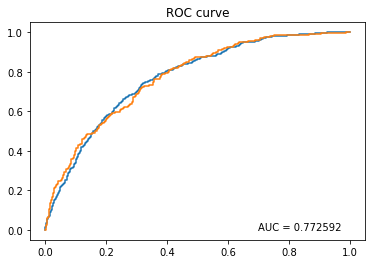

In [95]:
#绘制ROC曲线
import sklearn.metrics as metrics
fpr_test,tpr_test,th_test=metrics.roc_curve(test.bad_ind,test.prop)
fpr_train,tpr_train,th_train=metrics.roc_curve(train.bad_ind,train.prop)
plt.plot(fpr_train,tpr_train)
plt.plot(fpr_test,tpr_test)
plt.title('ROC curve')
plt.text(0.7,0.0,'AUC = %f'%metrics.auc(fpr_test,tpr_test))

In [96]:
#计算评估指标
print(metrics.classification_report(test.bad_ind,test.prediction))

             precision    recall  f1-score   support

          0       0.79      1.00      0.88       970
          1       0.67      0.01      0.02       261

avg / total       0.76      0.79      0.70      1231



prediction,0,1,All
bad_ind,,,
0,951,19,970
1,224,37,261
All,1175,56,1231


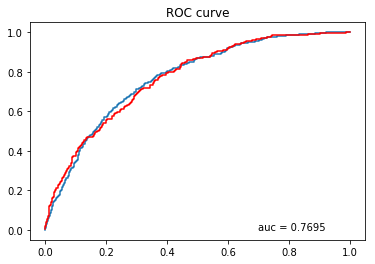

In [103]:
#statsmodel会默认进行标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = ['fico_score' ,'ltv' ,'age_oldest_tr' ,'tot_derog']
train1 = train[cols];test1=test[cols]
train2 = pd.DataFrame(scaler.fit_transform(train1),index=train1.index,columns=train1.columns)
test2 = pd.DataFrame(scaler.fit_transform(test1),index=test1.index,columns=test1.columns)
train3 = train2.join(train[['bad_ind','bankruptcy_ind']])
test3 = test2.join(test[['bad_ind','bankruptcy_ind']])
formula2 = 'bad_ind~bankruptcy_ind+'+'+'.join(cols)
lr_m2 = smf.glm(formula2,data = train3,family=sm.families.Binomial(sm.families.links.logit)).fit()
train3['prop'] = lr_m2.predict(train3)
test3['prop'] = lr_m2.predict(test3)
fpr_train3,tpr_train3,th_train3 = metrics.roc_curve(train3.bad_ind,train3.prop)
fpr_test3,tpr_test3,th_test3 = metrics.roc_curve(test3.bad_ind,test3.prop)
plt.plot(fpr_train3,tpr_train3)
plt.plot(fpr_test3,tpr_test3,color='r')
plt.title('ROC curve')
plt.text(0.7,0,'auc = %.4f'%metrics.auc(fpr_test3,tpr_test3))
test3['prediction'] = (test3['prop']>0.5).astype('int')
pd.crosstab(test3.bad_ind,test3.prediction,margins=True)